2015 Dataset Shape: (22324, 17)
2025 Dataset Shape: (21359, 17)
Combined Dataset Shape: (43683, 17)
Missing Values:
 movie_id                          0
movie_title                       0
year                              0
director                          0
actors                            0
duration                          0
genres                            0
overall_rating                    0
total_reviews                     0
box_office_worldwide           6256
box_office_domestic           11290
reviewer                          0
user_rating                   38073
review_title                      2
review_text                       0
review_date                       0
year_group                        0
duration_minutes                  0
box_office_worldwide_clean     6406
box_office_domestic_clean     11290
genres_list                       0
dtype: int64
Unique Movies:
          movie_id                              movie_title  year  \
0       tt3682448             

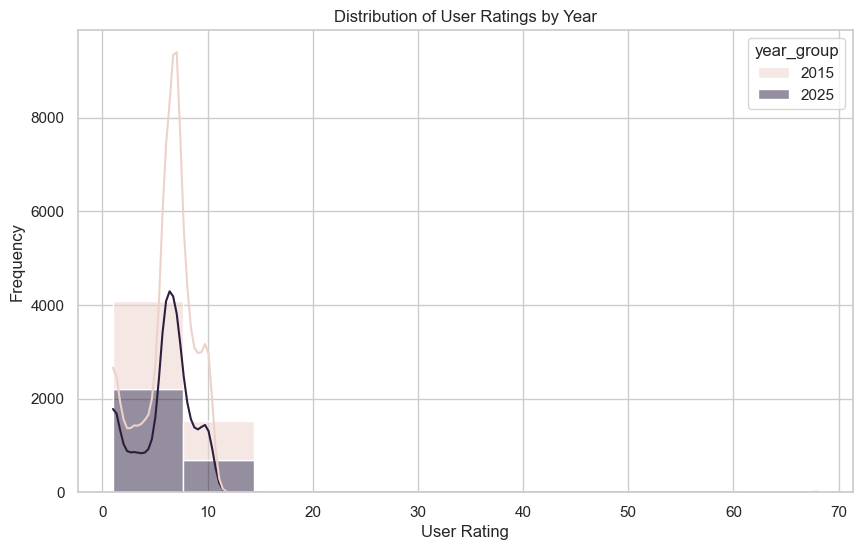

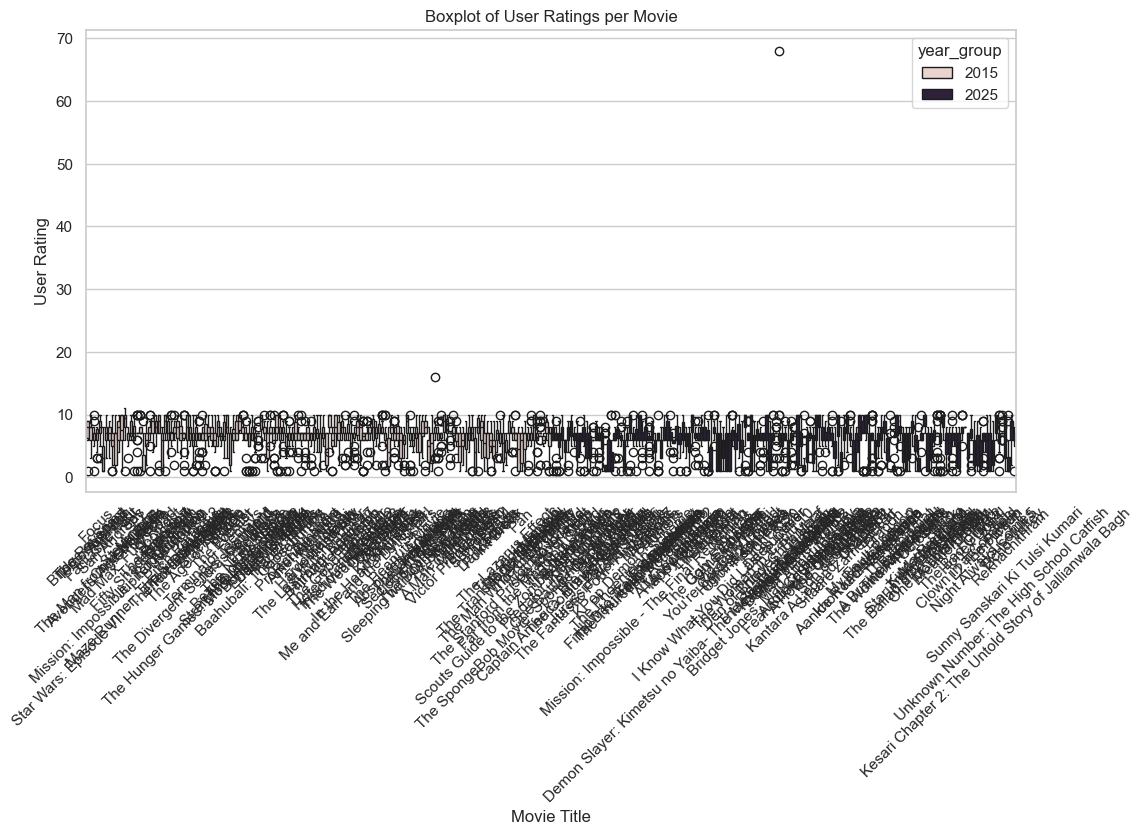

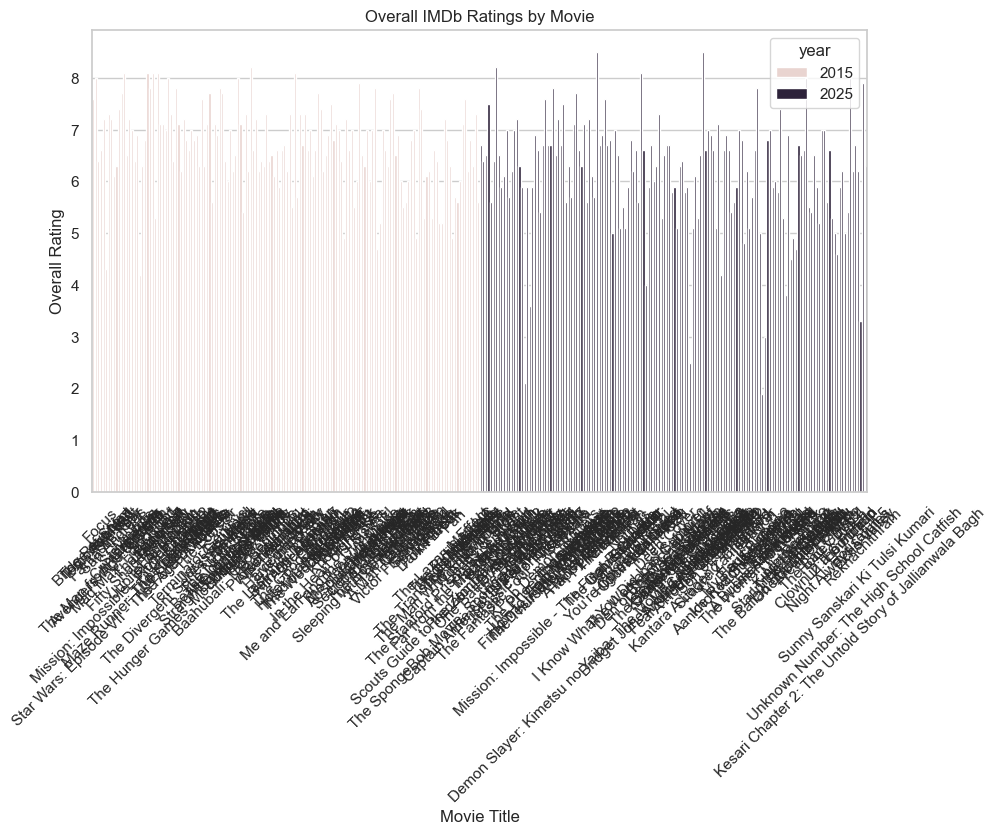

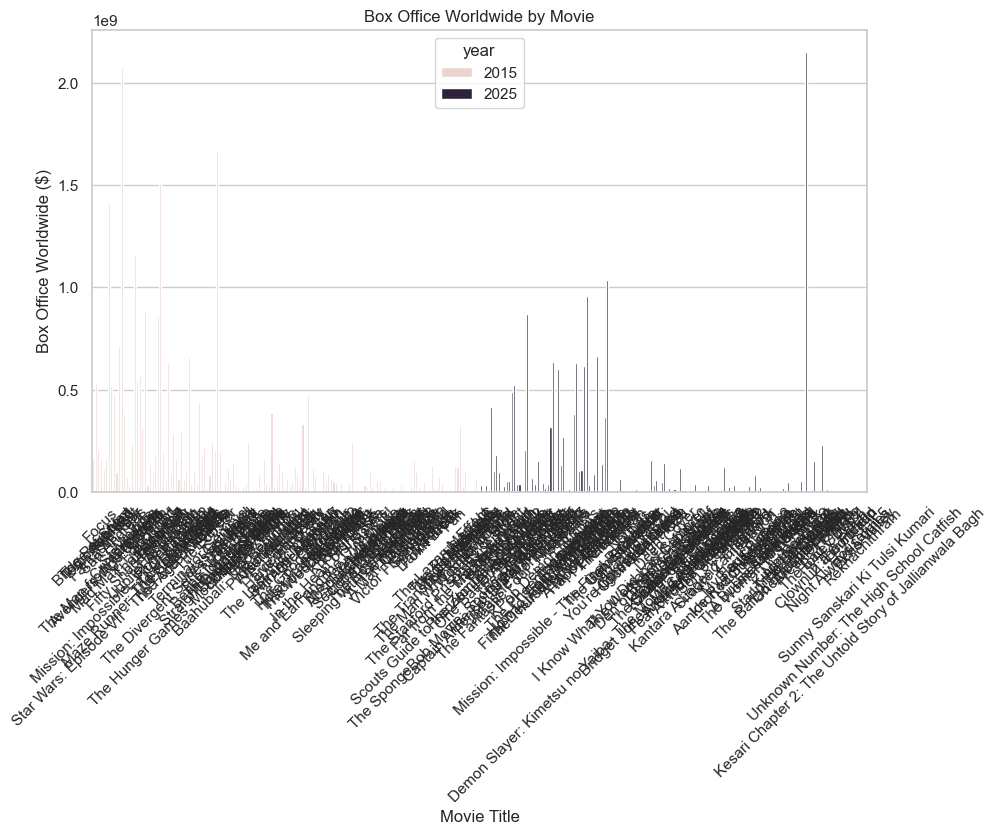

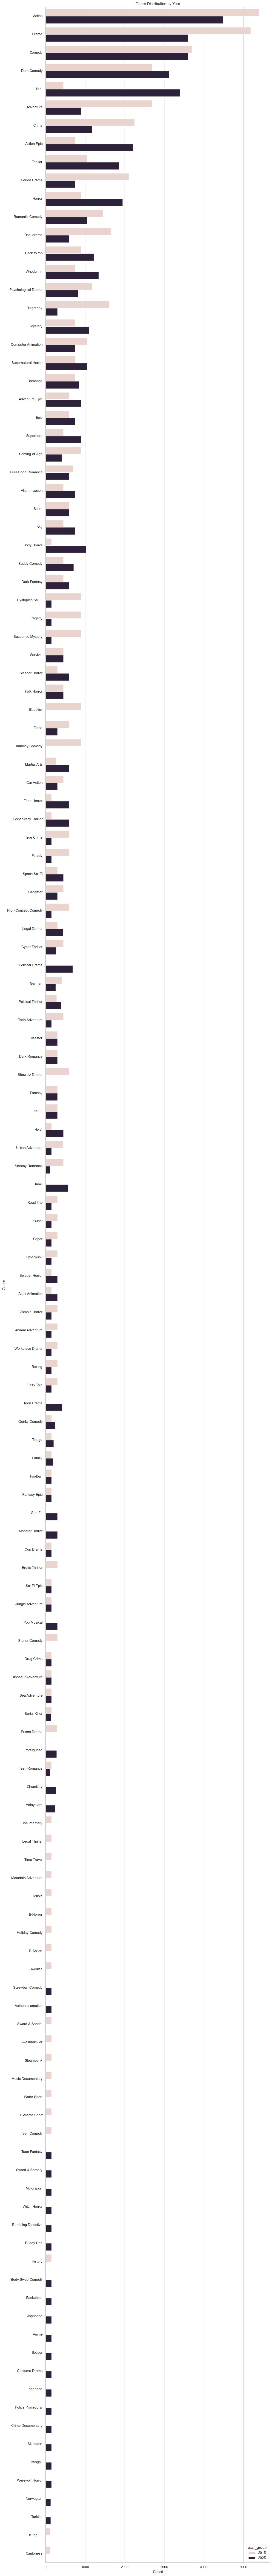

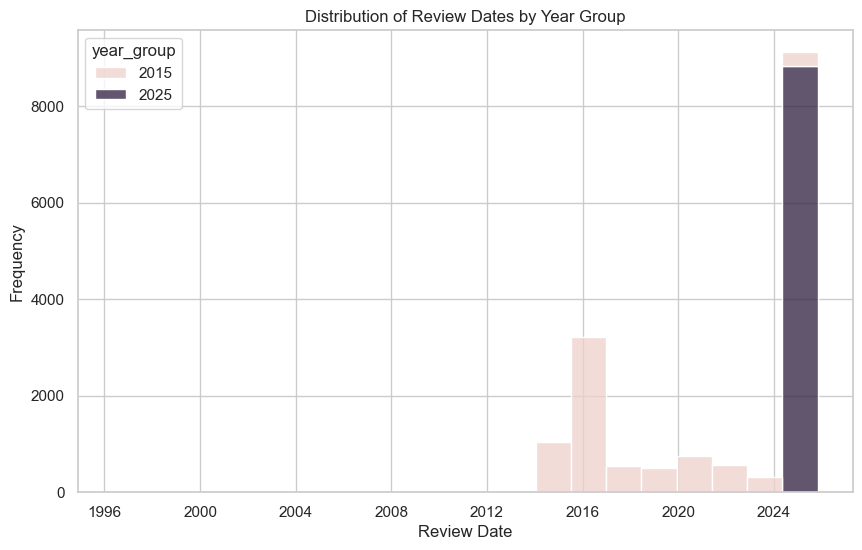

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from io import StringIO

sns.set(style="whitegrid")
%matplotlib inline

df_2015 = pd.read_csv('imdb_2015_final_dataset.csv')
df_2025 = pd.read_csv('imdb_2025_final_dataset.csv')

df_2015['year_group'] = 2015
df_2025['year_group'] = 2025

df_combined = pd.concat([df_2015, df_2025], ignore_index=True)

print("2015 Dataset Shape:", df_2015.shape)
print("2025 Dataset Shape:", df_2025.shape)
print("Combined Dataset Shape:", df_combined.shape)
df_combined.head()

def duration_to_minutes(duration):
    if pd.isna(duration):
        return None
    hours = 0
    minutes = 0
    h_match = re.search(r'(\d+)h', duration)
    if h_match:
        hours = int(h_match.group(1))
    m_match = re.search(r'(\d+)m', duration)
    if m_match:
        minutes = int(m_match.group(1))
    return hours * 60 + minutes

def clean_box_office(value):
    if pd.isna(value) or value == 'N/A' or not isinstance(value, str):
        return float('nan')
    cleaned = value.replace('$', '').replace(',', '').strip()
    if not cleaned or cleaned == '.':
        return float('nan')
    try:
        return float(cleaned)
    except ValueError:
        return float('nan')

df_combined['user_rating'] = pd.to_numeric(df_combined['user_rating'], errors='coerce')
df_combined['duration_minutes'] = df_combined['duration'].apply(duration_to_minutes)
df_combined['box_office_worldwide_clean'] = df_combined['box_office_worldwide'].apply(clean_box_office)
df_combined['box_office_domestic_clean'] = df_combined['box_office_domestic'].apply(clean_box_office)
df_combined['genres_list'] = df_combined['genres'].apply(lambda x: x.split(', ') if pd.notna(x) else [])

print("Missing Values:\n", df_combined.isnull().sum())

unique_movies = df_combined[['movie_id', 'movie_title', 'year', 'overall_rating', 'total_reviews', 'box_office_worldwide_clean', 'box_office_domestic_clean']].drop_duplicates()
print("Unique Movies:\n", unique_movies)

print("Summary Statistics for Numerical Columns:\n", df_combined.describe())

print("Summary by Year:\n", df_combined.groupby('year_group')[['overall_rating', 'total_reviews', 'user_rating', 'duration_minutes', 'box_office_worldwide_clean', 'box_office_domestic_clean']].mean())

per_movie_stats = df_combined.groupby('movie_title').agg({
    'user_rating': ['mean', 'median', 'std', 'count'],
    'overall_rating': 'first',
    'total_reviews': 'first',
    'box_office_worldwide_clean': 'first',
    'box_office_domestic_clean': 'first'
})
print("Per-Movie Statistics:\n", per_movie_stats)

plt.figure(figsize=(10, 6))
sns.histplot(data=df_combined, x='user_rating', hue='year_group', multiple='stack', bins=10, kde=True)
plt.title('Distribution of User Ratings by Year')
plt.xlabel('User Rating')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_combined, x='movie_title', y='user_rating', hue='year_group')
plt.title('Boxplot of User Ratings per Movie')
plt.xlabel('Movie Title')
plt.ylabel('User Rating')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=unique_movies, x='movie_title', y='overall_rating', hue='year')
plt.title('Overall IMDb Ratings by Movie')
plt.xlabel('Movie Title')
plt.ylabel('Overall Rating')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=unique_movies, x='movie_title', y='box_office_worldwide_clean', hue='year')
plt.title('Box Office Worldwide by Movie')
plt.xlabel('Movie Title')
plt.ylabel('Box Office Worldwide ($)')
plt.xticks(rotation=45)
plt.show()

df_genres = df_combined.explode('genres_list')

unique_genres = df_genres['genres_list'].nunique()
fig_height = max(6, unique_genres * 0.8)

plt.figure(figsize=(12, fig_height))
sns.countplot(data=df_genres, y='genres_list', hue='year_group', order=df_genres['genres_list'].value_counts().index)
plt.title('Genre Distribution by Year')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.yticks(fontsize=11, va='center', ha='right')
plt.subplots_adjust(left=0.2)
plt.tight_layout()
plt.show()

df_combined['review_date'] = pd.to_datetime(df_combined['review_date'], errors='coerce')

plt.figure(figsize=(10, 6))
sns.histplot(data=df_combined, x='review_date', hue='year_group', multiple='stack', bins=20)
plt.title('Distribution of Review Dates by Year Group')
plt.xlabel('Review Date')
plt.ylabel('Frequency')
plt.show()